# Agent Metrics Analysis

This notebook processes and visualizes agent metrics from the monitor.csv file.

In [103]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
import numpy as np
import seaborn as sns

In [2]:
from __future__ import annotations

import glob
import os
import time
import csv

import supersuit as ss
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from scipy import stats

import gymnasium as gym 

from pettingzoo.sisl import waterworld_v4, waterworld_model1

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.evaluation import evaluate_policy
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, CheckpointCallback

import numpy as np 
import pandas as pd

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor


## Set the log directory and process the data

In [89]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
log_dir = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240819-135152/"
latest_policy = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240819-135152/rl_model_640000_steps.zip"

model = RecurrentPPO.load(latest_policy)


In [90]:
obs = env.reset()

    # Cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
    # Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)
num_games = 10 

In [93]:
print(f"Starting eval on {str(env.metadata['name'])}.")
# Initialize data structures to store step-wise information
all_data = []

for game in range(num_games):
    env.reset(seed=game+90)
    print(f"Game {game}")
        
    game_data = {agent: {
            'rewards': [],
            'arousal': [],
            'satiety': [],
            'social-touch': [],
            'step': []
    } for agent in env.possible_agents}

    step = 0
    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
            
            
        for a in env.agents:
            game_data[a]['rewards'].append(env.rewards[a])
            game_data[a]['step'].append(step)
                
            for metric in ['arousal', 'satiety', 'social-touch']:
                if metric in info:
                    agent_name = info[metric].split('_')[0] + "_" + info[metric].split('_')[1]
                    if a != agent_name:
                        print("DANGER")
                        print(a)
                        print(agent_name)
                    value = float(info[metric].split('_')[-1])
                    game_data[agent_name][metric].append(value)
                else:
                    game_data[a][metric].append(None)  # or some default value

        if termination or truncation:
            break
        else:
            act = model.predict(obs, deterministic=True)[0]
            
        env.step(act)
        step += 1

    # Convert game data to DataFrame and add to all_data
    for agent, data in game_data.items():
        df = pd.DataFrame(data)
        df['agent'] = agent
        df['game'] = game
        all_data.append(df)

env.close()

# Combine all game data
df = pd.concat(all_data, ignore_index=True)


Starting eval on waterworld_model1.
Game 0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursu

In [94]:
info

{'arousal': 'pursuer_0_0.4238917442344381',
 'satiety': 'pursuer_0_1.4156901027663924',
 'social-touch': 'pursuer_0_0'}

In [ ]:
'''
for agent in env.agent_iter():
    obs, reward, termination, truncation, info = env.last()

    for a in env.agents:
        rewards[a] += env.rewards[a]
        print("reward for agent " + str(a) + " = " + str(rewards[a]))
                # Parse and store metrics
        for metric in ['arousal', 'satiety', 'social_touch']:
            if metric in info:
                value = float(info[metric].split('_')[-1])  # Extract the float value
                episode_metrics[a][metric].append(value)

    if termination or truncation:
        break
    else:
        act, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)

    env.step(act)
'''

In [95]:
# Combine all game data
df = pd.concat(all_data, ignore_index=True)


In [97]:
# Print overall evaluation results
print("\nOverall Evaluation Results:")
for agent in env.possible_agents:
    agent_data = df[df['agent'] == agent]
    print(f"Agent {agent}:")
    print(f"  Total Reward: {agent_data['rewards'].sum():.4f}")
    for metric in ['arousal', 'satiety', 'social-touch']:
        print(f"  {metric.capitalize()}: Mean = {agent_data[metric].mean():.4f}, Std = {agent_data[metric].std():.4f}")



Overall Evaluation Results:
Agent pursuer_0:
  Total Reward: 10462.9571
  Arousal: Mean = 0.5090, Std = 0.0675
  Satiety: Mean = 0.6247, Std = 0.5289
  Social-touch: Mean = -0.0002, Std = 0.0014
Agent pursuer_1:
  Total Reward: 18900.8851
  Arousal: Mean = 0.5032, Std = 0.0834
  Satiety: Mean = 0.9578, Std = 0.4891
  Social-touch: Mean = 0.0000, Std = 0.0000


In [99]:
df['social-touch']

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
20015    0.0
20016    0.0
20017    0.0
20018    0.0
20019    0.0
Name: social-touch, Length: 20020, dtype: float64

PLOT RESULTS 

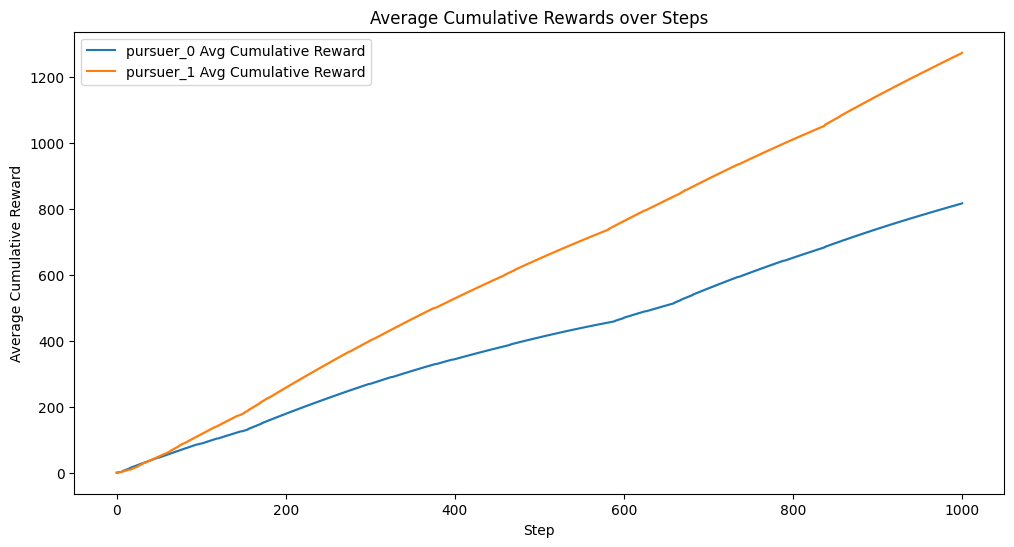

In [82]:
# Create a directory for plots if it doesn't exist
plot_dir = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240819-135152/"

# Plot cumulative rewards
plt.figure(figsize=(12, 6))
for agent in df['agent'].unique():
    agent_data = df[df['agent'] == agent]
    cumulative_rewards = agent_data.groupby(['game', 'step'])['rewards'].sum().groupby('step').mean().cumsum()
    plt.plot(cumulative_rewards.index, cumulative_rewards.values, label=f'{agent} Avg Cumulative Reward')
plt.title('Average Cumulative Rewards over Steps')
plt.xlabel('Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
plt.savefig(f"{plot_dir}/avg_cumulative_rewards.png")

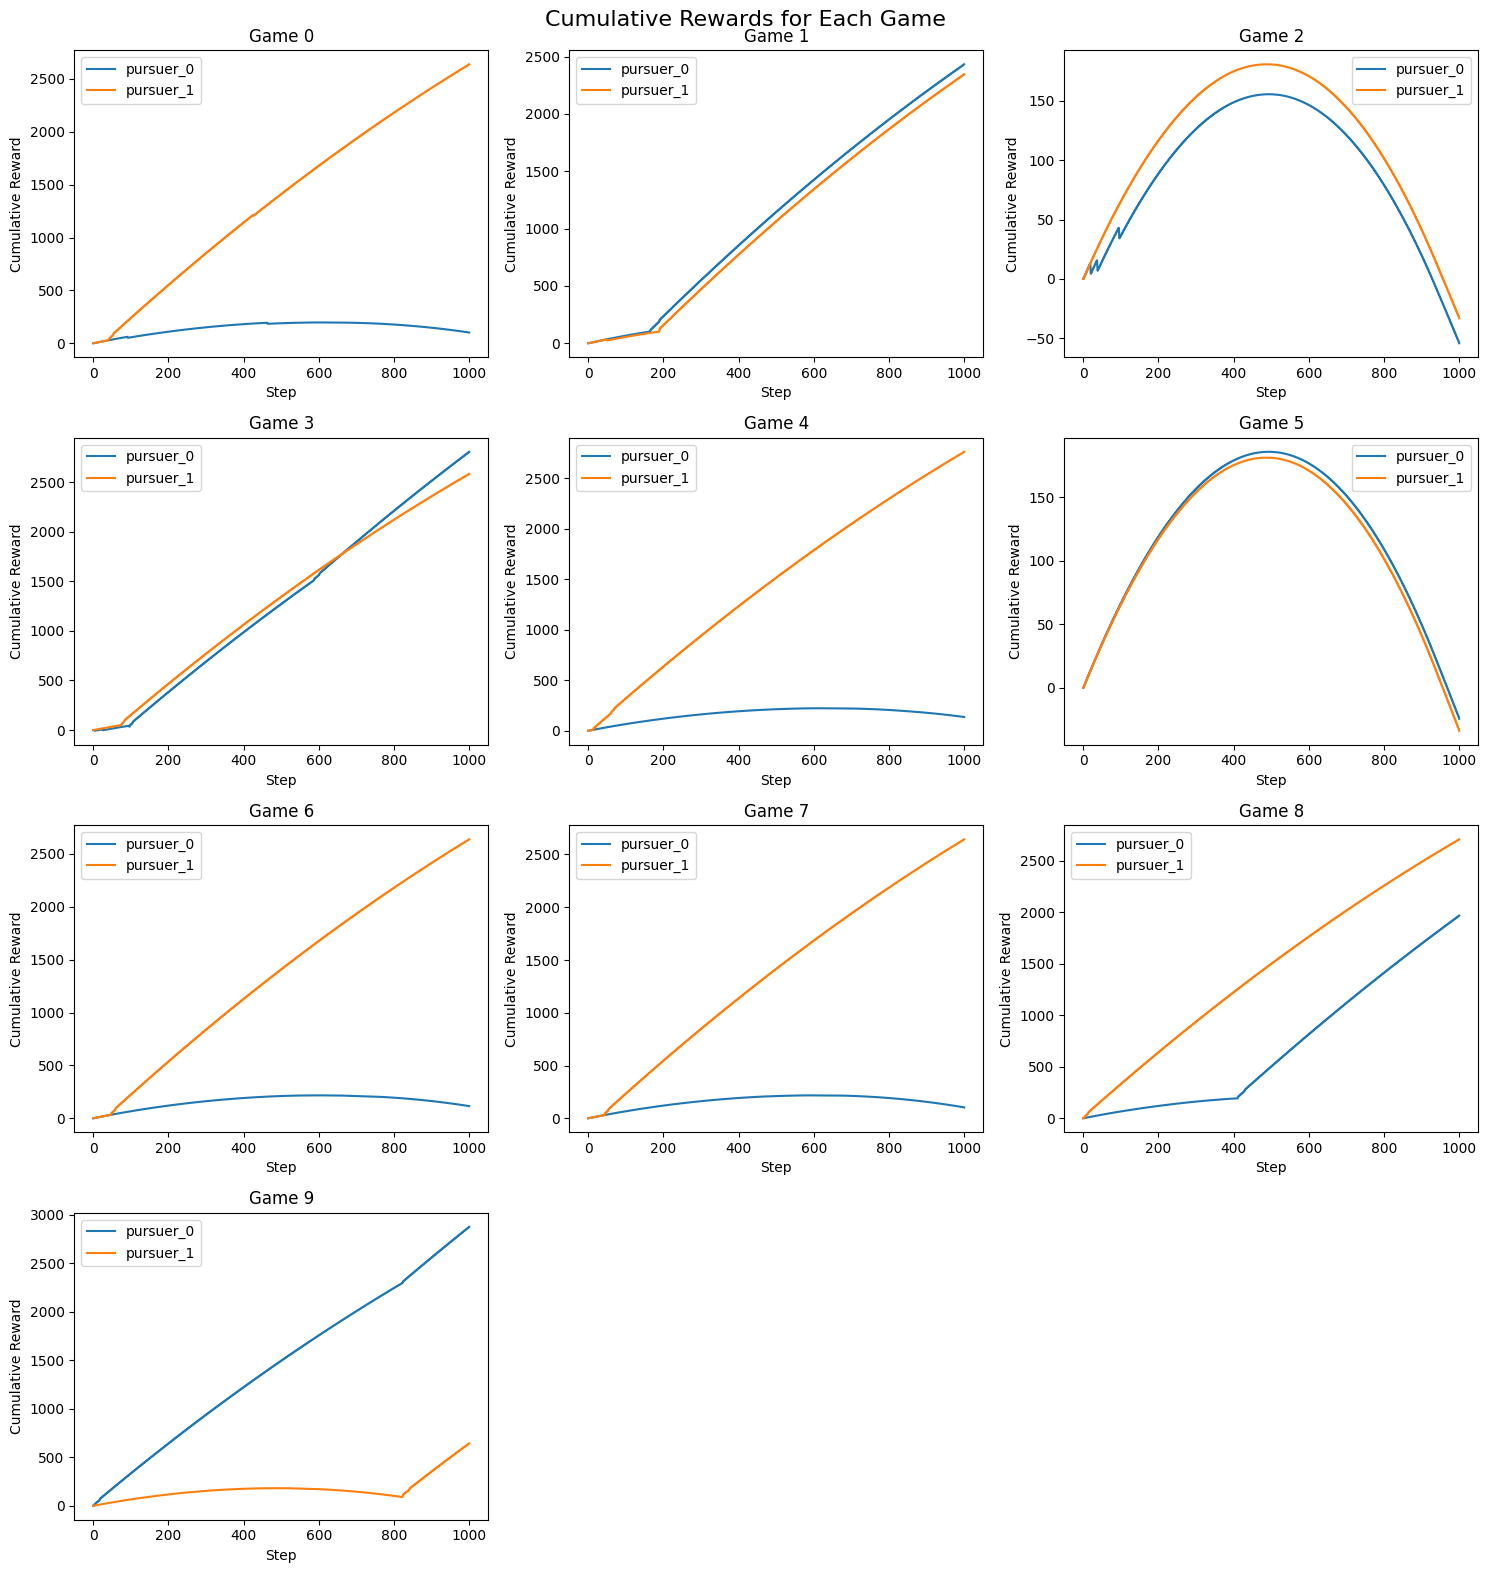

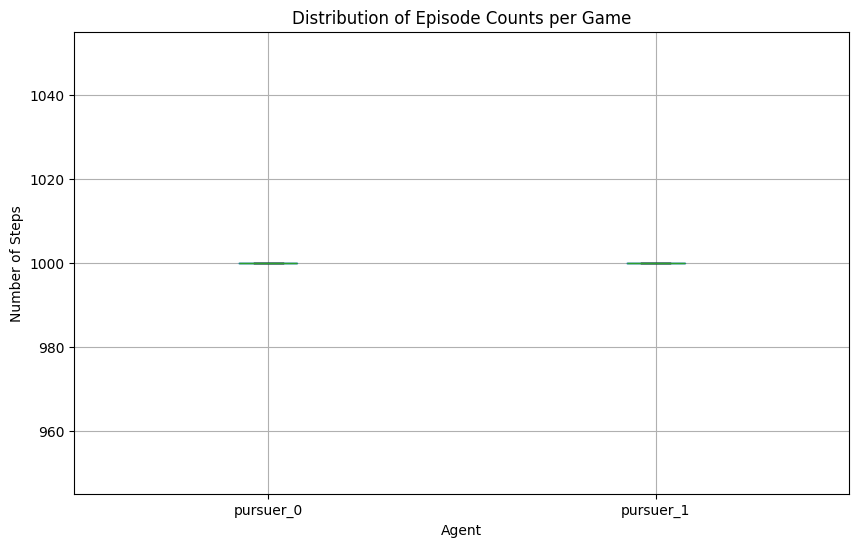

In [100]:
 # Plot cumulative rewards for each game in subplots
num_games = df['game'].nunique()
num_cols = 3  # You can adjust this to change the number of columns in the subplot grid
num_rows = (num_games - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows), squeeze=False)
fig.suptitle('Cumulative Rewards for Each Game', fontsize=16)

for game, ax in zip(df['game'].unique(), axes.flatten()):
    game_data = df[df['game'] == game]
    for agent in game_data['agent'].unique():
        agent_data = game_data[game_data['agent'] == agent]
        cumulative_rewards = agent_data['rewards'].cumsum()
        ax.plot(agent_data['step'], cumulative_rewards, label=agent)
    ax.set_title(f'Game {game}')
    ax.set_xlabel('Step')
    ax.set_ylabel('Cumulative Reward')
    ax.legend()

# Remove any unused subplots
for ax in axes.flatten()[num_games:]:
    ax.remove()

plt.tight_layout()
plt.savefig(f"{plot_dir}/cumulative_rewards_by_game.png")


# Box plot for number of episodes
episode_counts = df.groupby(['game', 'agent'])['step'].max().unstack()
plt.figure(figsize=(10, 6))
episode_counts.boxplot()
plt.title('Distribution of Episode Counts per Game')
plt.xlabel('Agent')
plt.ylabel('Number of Steps')
plt.savefig(f"{plot_dir}/episode_count_boxplot.png")


    

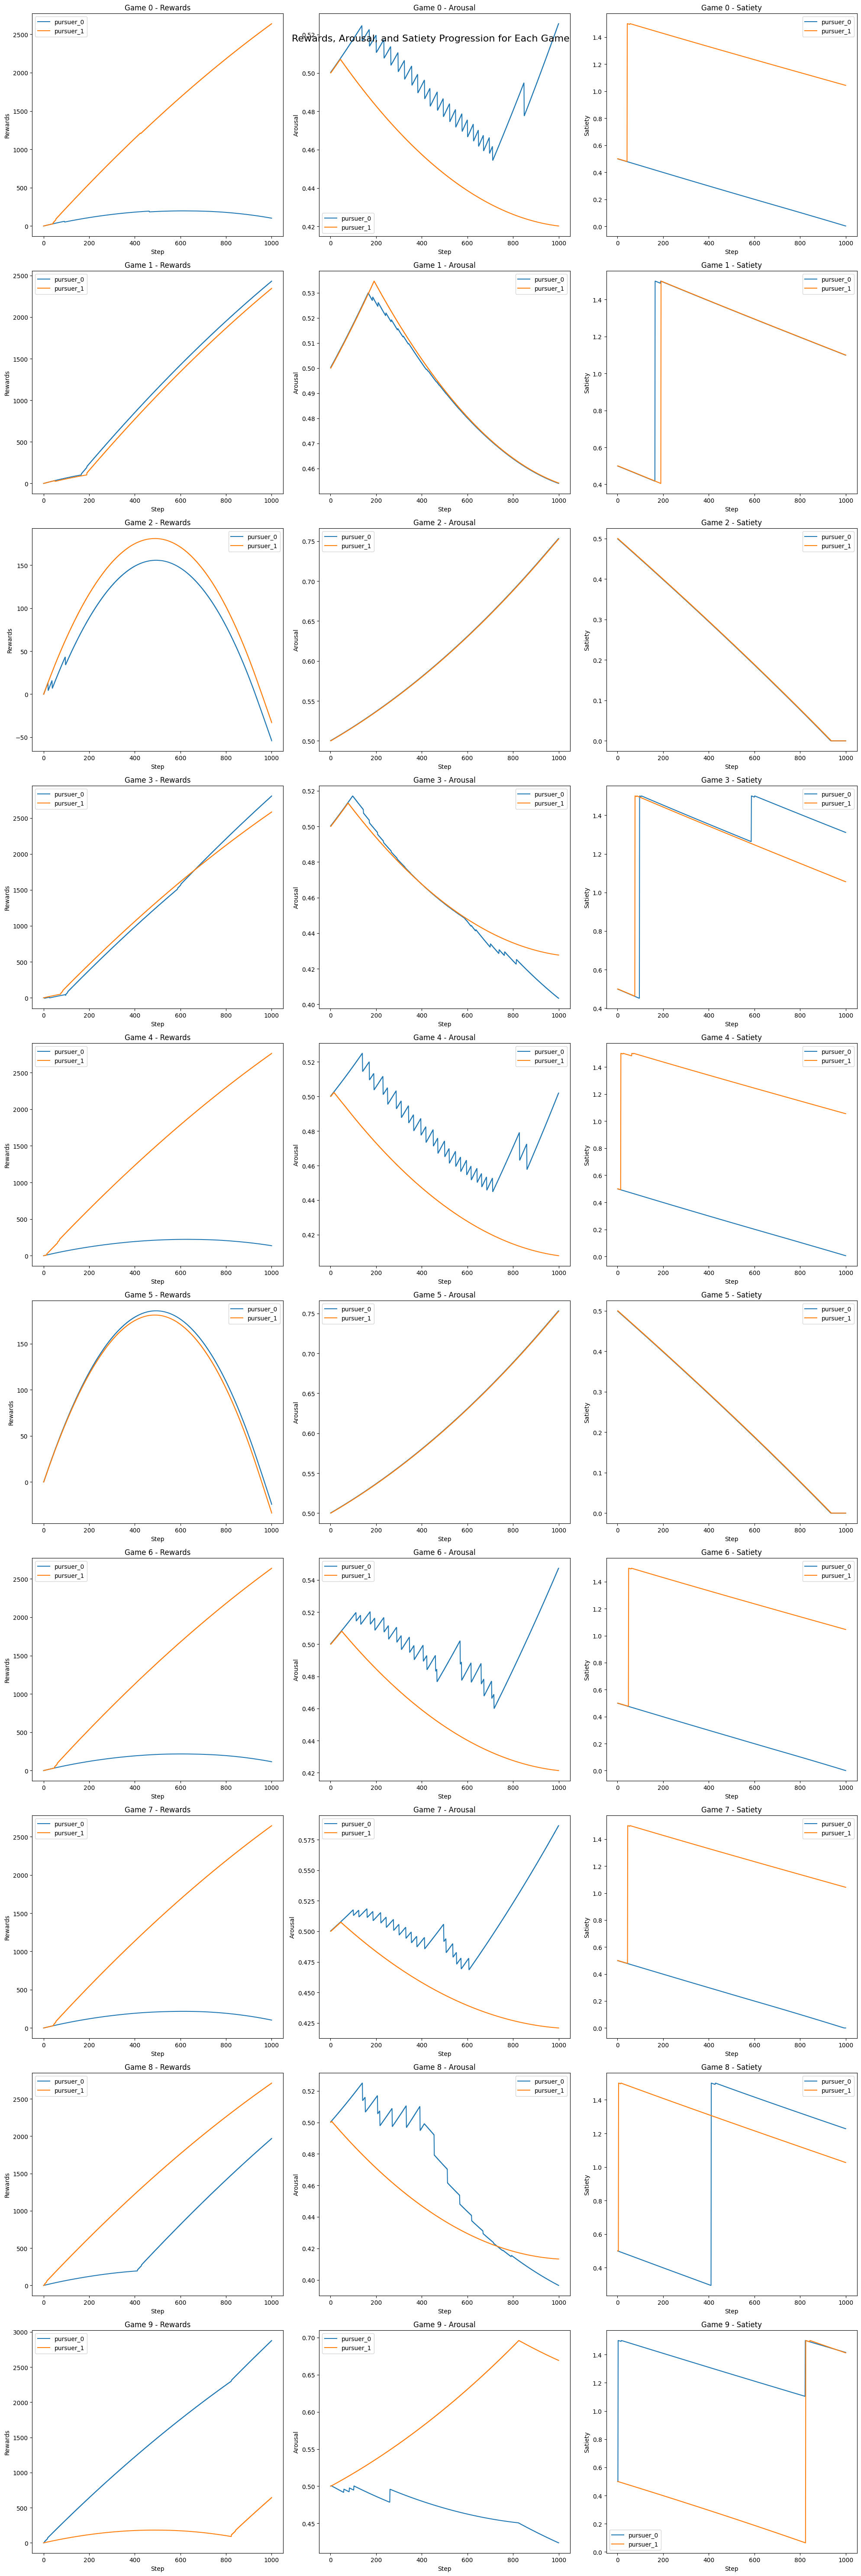

In [101]:
# Create comprehensive plot for rewards, arousal, and satiety for each game
num_games = df['game'].nunique()
fig, axes = plt.subplots(num_games, 3, figsize=(20, 6*num_games), squeeze=False)
fig.suptitle('Rewards, Arousal, and Satiety Progression for Each Game', fontsize=16)

metrics = ['rewards', 'arousal', 'satiety']
for game, ax_row in zip(sorted(df['game'].unique()), axes):
    game_data = df[df['game'] == game]
    
    for metric, ax in zip(metrics, ax_row):
        for agent in game_data['agent'].unique():
            agent_data = game_data[game_data['agent'] == agent]
            if metric == 'rewards':
                values = agent_data[metric].cumsum()
            else:
                values = agent_data[metric]
            ax.plot(agent_data['step'], values, label=agent)
        
        ax.set_title(f'Game {game} - {metric.capitalize()}')
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.capitalize())
        ax.legend()

plt.tight_layout()
plt.savefig(f"{plot_dir}/comprehensive_game_metrics.png")


In [104]:
from scipy import stats

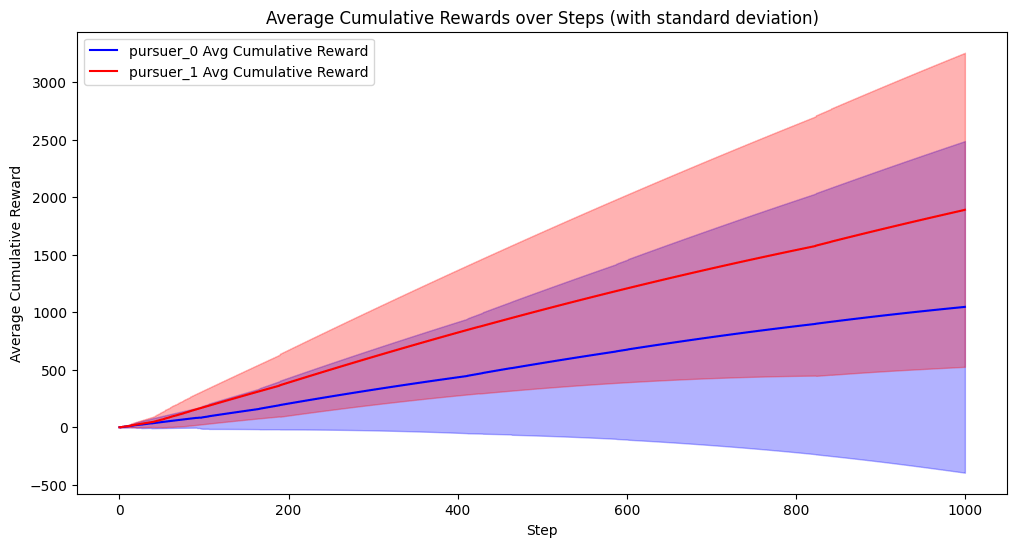

In [107]:
# Plot average cumulative rewards with shaded areas
plt.figure(figsize=(12, 6))
colors = {'pursuer_0': 'blue', 'pursuer_1': 'red'}
for agent in df['agent'].unique():
    try:
        agent_data = df[df['agent'] == agent]
        grouped = agent_data.groupby(['game', 'step'])['rewards'].sum().astype(float).groupby('step')
        cumulative_rewards_mean = grouped.mean().cumsum()
        cumulative_rewards_std = grouped.std().cumsum()
        
        steps = cumulative_rewards_mean.index
        mean_values = cumulative_rewards_mean.values
        std_values = cumulative_rewards_std.values
        
        plt.plot(steps, mean_values, label=f'{agent} Avg Cumulative Reward', color=colors[agent])
        plt.fill_between(steps, 
                         mean_values - std_values, 
                         mean_values + std_values, 
                         alpha=0.3, 
                         color=colors[agent])
    except Exception as e:
        print(f"Warning: Could not plot average cumulative rewards for agent {agent}. Error: {str(e)}")
        continue

plt.title('Average Cumulative Rewards over Steps (with standard deviation)')
plt.xlabel('Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
plt.savefig(f"{plot_dir}/avg_cumulative_rewards_shaded.png")

/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc


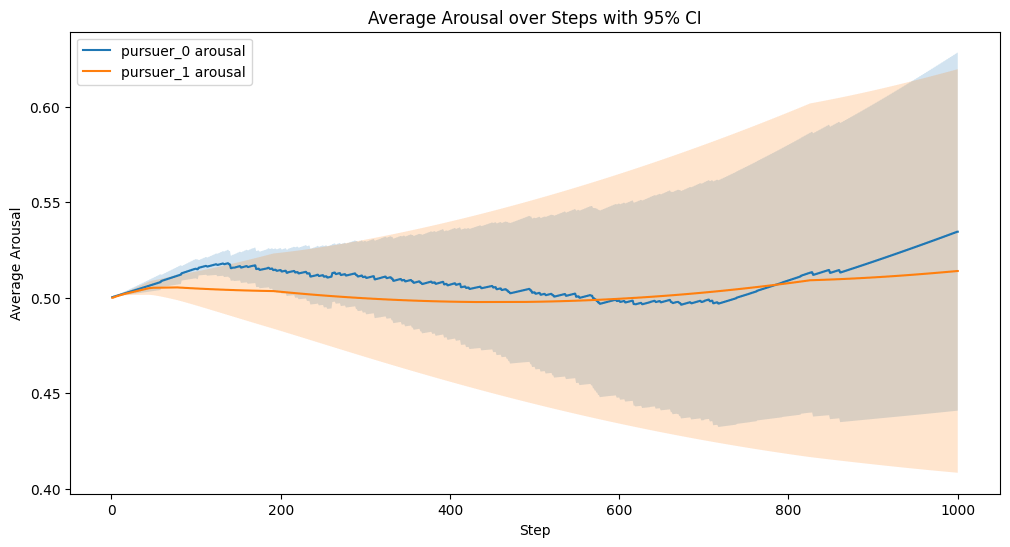

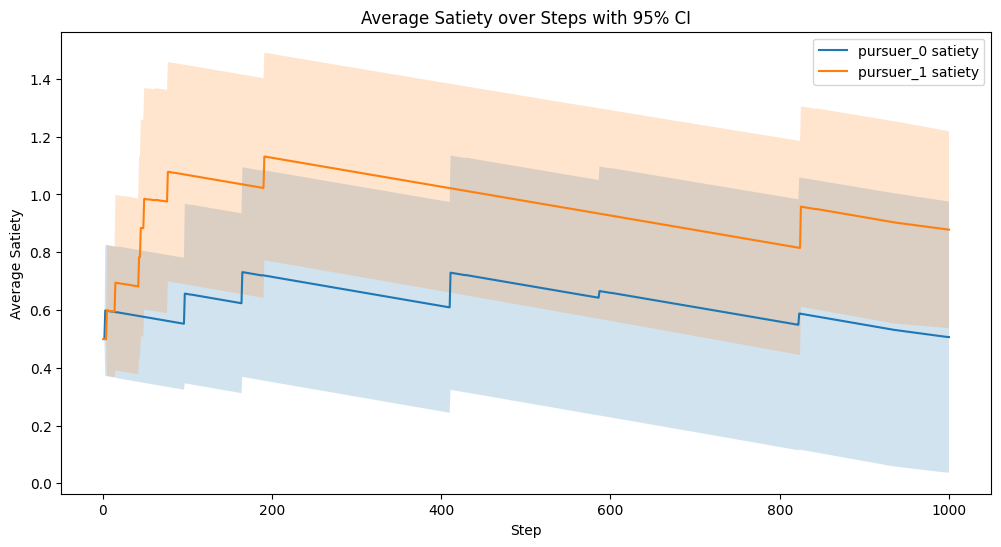

In [110]:
# Plot average metrics with confidence intervals
for metric in metrics[1:]:
    plt.figure(figsize=(12, 6))
    for agent in df['agent'].unique():
        try:
            agent_data = df[df['agent'] == agent]
            numeric_data = agent_data[metric].astype(float)
            means = numeric_data.groupby(agent_data['step']).mean()
            
            def calculate_ci(x):
                try:
                    return stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x))
                except:
                    return (np.nan, np.nan)
            
            ci = numeric_data.groupby(agent_data['step']).agg(calculate_ci)
            ci_lower = [x[0] for x in ci]
            ci_upper = [x[1] for x in ci]
            
            plt.plot(means.index, means.values, label=f'{agent} {metric}')
            plt.fill_between(means.index, ci_lower, ci_upper, alpha=0.2)
        except Exception as e:
            print(f"Warning: Could not plot {metric} for agent {agent}. Error: {str(e)}")
            continue
    
    plt.title(f'Average {metric.capitalize()} over Steps with 95% CI')
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.legend()
    plt.savefig(f"{plot_dir}/{metric}_avg_with_ci.png")
    


In [113]:
plt.figure(figsize=(10, 8))
numeric_df = df[metrics].astype(float)
corr_df = numeric_df.groupby(df['agent']).apply(lambda x: x.corr()).reset_index()




<Figure size 1000x800 with 0 Axes>

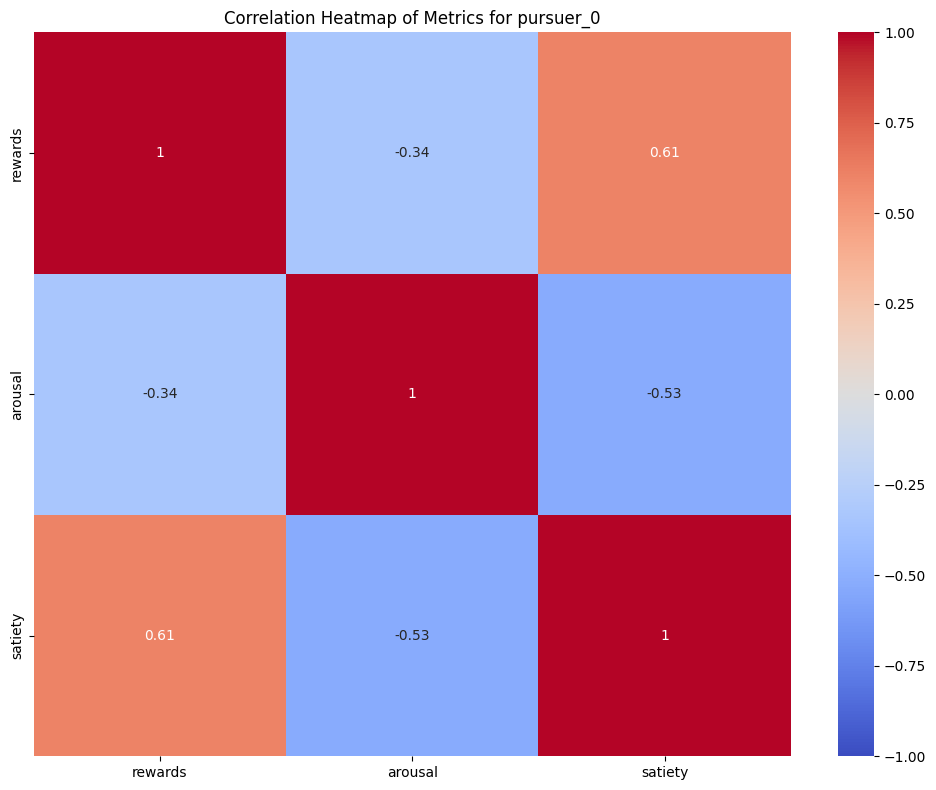

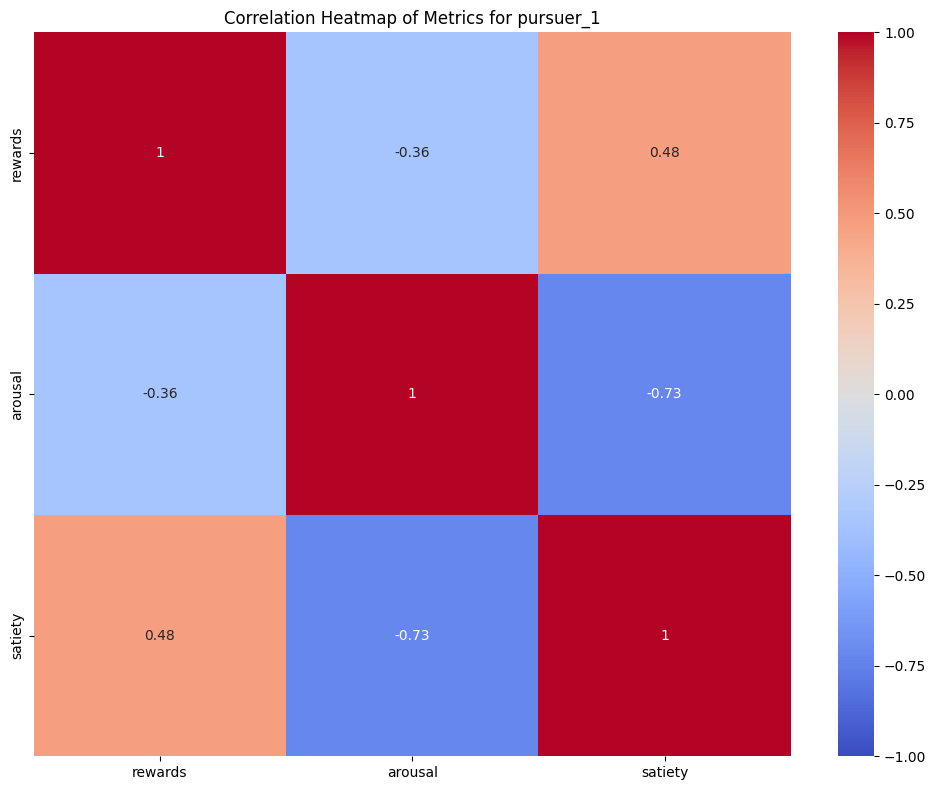

In [126]:
for agent in df['agent'].unique():
    plt.figure(figsize=(10, 8))
    agent_data = df[df['agent'] == agent]
    numeric_data = agent_data[metrics].astype(float)
    corr_matrix = numeric_data.corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Heatmap of Metrics for {agent}')
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/correlation_heatmap_{agent}.png")
